# Importing Modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math

In [ ]:
torch.autograd.set_detect_anomaly(True)

# Common Functions

In [ ]:
def generate_dataset(number_of_samples: int, max_length: int):
    x = []
    y = np.zeros((number_of_samples))
    for i in range(number_of_samples):
        length = np.random.randint(3, max_length + 1)
        random_values = np.random.rand(length)
        target_index1, target_index2 = np.random.choice(length, 2, replace=False)
        new_x = np.zeros((length, 2))
        new_x[:, 0] = random_values
        new_x[target_index1, 1] = 1
        new_x[target_index2, 1] = 1
        x.append(new_x)
        y[i] = random_values[target_index1] + random_values[target_index2]

    x = np.array(x)
    return x, y

In [ ]:
def train(model, x, y, learning_rate, number_of_epochs):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.functional.mse_loss
    loss_history = []
    for epoch in range(number_of_epochs):
        loss = 0
        for i in range(x.shape[0]):
            optimizer.zero_grad()
            x_i = torch.tensor(x[i], dtype=torch.float32)
            y_i = torch.tensor(y[i], dtype=torch.float32)
            y_pred = model.forward(x_i)
            loss_i = loss_fn(y_pred, y_i)
            loss_i.backward()
            optimizer.step()
            loss += loss_i.item()
        print("===========> Epoch: {}, Loss: {}".format(epoch + 1, loss / x.shape[0]))
        loss_history.append(loss / x.shape[0])
    return loss_history

In [ ]:
def test(model, x, y):
    model.eval()
    loss_fn = nn.functional.mse_loss
    loss = 0
    for i in range(x.shape[0]):
        x_i = torch.tensor(x[i], dtype=torch.float32)
        y_i = torch.tensor(y[i], dtype=torch.float32)
        y_pred = model.forward(x_i)
        loss_i = loss_fn(y_pred, y_i)
        loss += loss_i.item()
    return loss / x.shape[0]

# Elman RNN

In [ ]:
class ElmanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, number_of_layers):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.number_of_layers = number_of_layers
        self.W_hh_list = nn.ParameterList([nn.Parameter(torch.randn(hidden_size, hidden_size)) for _ in range(number_of_layers)])
        self.W_ih_list = nn.ParameterList([nn.Parameter(torch.randn(hidden_size, input_size if layer == 0 else hidden_size)) for layer in range(number_of_layers)])
        self.W_ho = nn.Parameter(torch.randn(output_size, hidden_size))
        self.b_h_list = nn.ParameterList([nn.Parameter(torch.randn(hidden_size)) for _ in range(number_of_layers)])
        self.b_o = nn.Parameter(torch.randn(output_size))

    def forward(self, x):
        h_list = [torch.zeros(self.hidden_size, 1) for _ in range(self.number_of_layers)]
        for x_t in x:
            curr_in = x_t.float()
            curr_in = torch.reshape(curr_in, (x_t.shape[0], 1))
            for i in range(self.number_of_layers):
                z_t = torch.matmul(self.W_ih_list[i], curr_in) + torch.matmul(self.W_hh_list[i], h_list[i]) + self.b_h_list[i]
                h_t = torch.tanh(z_t.float())
                curr_in = h_t.float()
                h_list[i] = h_t.float()
        Y = torch.matmul(self.W_ho, h_list[-1]) + self.b_o
        return Y[-1][-1]



In [ ]:
number_train_samples = 5000
number_test_samples = 1000
max_length = 10
x_train, y_train = generate_dataset(number_train_samples, max_length)
x_test, y_test = generate_dataset(number_test_samples, max_length)
input_size = 2
hidden_size = 64
output_size = 1
number_of_layers = 5
learning_rate = 0.01
number_of_epochs = 20
print("Training data shape: ", x_train.shape)
print("Testing data shape: ", x_test.shape)
print("Training labels shape: ", y_train.shape)
print("Testing labels shape: ", y_test.shape)

Training data shape:  (5000,)
Testing data shape:  (1000,)
Training labels shape:  (5000,)
Testing labels shape:  (1000,)


In [ ]:
print("********** Training Elman RNN **********")
print("Number of layers: ", number_of_layers)
print("Hidden size: ", hidden_size)
print("Learning rate: ", learning_rate)
print("Number of epochs: ", number_of_epochs)
print()

elman = ElmanRNN(input_size, hidden_size, output_size, number_of_layers)
loss_history = train(elman, x_train, y_train, learning_rate, number_of_epochs)

********** Training Elman RNN **********
Number of layers:  5
Hidden size:  64
Learning rate:  0.01
Number of epochs:  20

===========> Epoch: 1, Loss: 2.567641789551101
===========> Epoch: 2, Loss: 0.34316394091971836
===========> Epoch: 3, Loss: 0.3081727584921511
===========> Epoch: 4, Loss: 0.28011502659927046
===========> Epoch: 5, Loss: 0.2719634023624034
===========> Epoch: 6, Loss: 0.27010077137188926
===========> Epoch: 7, Loss: 0.2953250236196818
===========> Epoch: 8, Loss: 0.3304742555979091
===========> Epoch: 9, Loss: 0.32687217150379055
===========> Epoch: 10, Loss: 0.3242091839352649
===========> Epoch: 11, Loss: 0.3239839052526706
===========> Epoch: 12, Loss: 0.33004131614040677
===========> Epoch: 13, Loss: 0.3331202207400504
===========> Epoch: 14, Loss: 0.33190063321553154
===========> Epoch: 15, Loss: 0.32810402270191924
===========> Epoch: 16, Loss: 0.31724266182188837
===========> Epoch: 17, Loss: 0.3138987590120007
===========> Epoch: 18, Loss: 0.31360583053656



********** Plotting **********


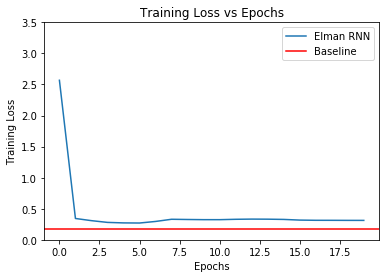

In [ ]:
print("\n\n********** Plotting **********")

y_baseline = np.ones((number_train_samples))
loss_baseline = np.mean((y_train - y_baseline) ** 2)

plt.plot(loss_history, label='Elman RNN')
plt.axhline(loss_baseline, label='Baseline', color='red')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Epochs')
plt.ylim(0, 3.5)
plt.savefig('elman.png')
plt.show()

In [ ]:

print("\n\n********** Testing Elman RNN **********")
loss = test(elman, x_test, y_test)
print("Testing loss: ", loss)



********** Testing Elman RNN **********
Testing loss:  0.2610992264534559


# LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, number_of_layers):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.number_of_layers = number_of_layers

        # forget gate weights
        self.W_if_list = nn.ParameterList([nn.Parameter(torch.randn(hidden_size, input_size if layer == 0 else hidden_size)) for layer in range(number_of_layers)])
        self.W_hf_list = nn.ParameterList([nn.Parameter(torch.randn(hidden_size, hidden_size)) for _ in range(number_of_layers)])
        self.b_f_list = nn.ParameterList([nn.Parameter(torch.randn(hidden_size)) for _ in range(number_of_layers)])

        # input gate weights
        self.W_ii_list = nn.ParameterList([nn.Parameter(torch.randn(hidden_size, input_size if layer == 0 else hidden_size)) for layer in range(number_of_layers)])
        self.W_hi_list = nn.ParameterList([nn.Parameter(torch.randn(hidden_size, hidden_size)) for _ in range(number_of_layers)])
        self.b_i_list = nn.ParameterList([nn.Parameter(torch.randn(hidden_size)) for _ in range(number_of_layers)])

        # cell weights
        self.W_ic_list = nn.ParameterList([nn.Parameter(torch.randn(hidden_size, input_size if layer == 0 else hidden_size)) for layer in range(number_of_layers)])
        self.W_hc_list = nn.ParameterList([nn.Parameter(torch.randn(hidden_size, hidden_size)) for _ in range(number_of_layers)])
        self.b_c_list = nn.ParameterList([nn.Parameter(torch.randn(hidden_size)) for _ in range(number_of_layers)])

        # output gate weights
        self.W_io_list = nn.ParameterList([nn.Parameter(torch.randn(hidden_size, input_size if layer == 0 else hidden_size)) for layer in range(number_of_layers)])
        self.W_ho_list = nn.ParameterList([nn.Parameter(torch.randn(hidden_size, hidden_size)) for _ in range(number_of_layers)])
        self.b_o_list = nn.ParameterList([nn.Parameter(torch.randn(hidden_size)) for _ in range(number_of_layers)])

        # output weights
        self.W_ho = nn.Parameter(torch.randn(output_size, hidden_size))
        self.b_o = nn.Parameter(torch.randn(output_size))

    def forward(self, x):
        h_list = [torch.zeros(self.hidden_size) for _ in range(self.number_of_layers)]
        c_list = [torch.zeros(self.hidden_size) for _ in range(self.number_of_layers)]

        for x_t in x:
            curr_in = x_t.float()
            curr_in = torch.reshape(curr_in, (x_t.shape[0], 1))
            for i in range(self.number_of_layers):
                ft = torch.sigmoid((torch.matmul(self.W_if_list[i], curr_in) + torch.matmul(self.W_hf_list[i], h_list[i]) + self.b_f_list[i]).float())
                it = torch.sigmoid((torch.matmul(self.W_ii_list[i], curr_in) + torch.matmul(self.W_hi_list[i], h_list[i]) + self.b_i_list[i]).float())
                c_t = torch.tanh((torch.matmul(self.W_ic_list[i], curr_in) + torch.matmul(self.W_hc_list[i], h_list[i]) + self.b_c_list[i]).float())
                ct = ft * c_list[i] + it * c_t
                ot = torch.sigmoid((torch.matmul(self.W_io_list[i], curr_in) + torch.matmul(self.W_ho_list[i], h_list[i]) + self.b_o_list[i]).float())
                ht = ot * torch.tanh(ct)
                curr_in = ht.float()
                h_list[i] = ht.float()
                c_list[i] = ct.float()

        Y = torch.matmul(self.W_ho, h_list[-1]) + self.b_o
        return Y[-1][-1]

In [ ]:
number_train_samples = 5000
number_test_samples = 1000
max_length = 10
x_train, y_train = generate_dataset(number_train_samples, max_length)
x_test, y_test = generate_dataset(number_test_samples, max_length)
input_size = 2
hidden_size = 64
output_size = 1
number_of_layers = 3
learning_rate = 0.01
number_of_epochs = 10
print("Training data shape: ", x_train.shape)
print("Testing data shape: ", x_test.shape)
print("Training labels shape: ", y_train.shape)
print("Testing labels shape: ", y_test.shape)

Training data shape:  (5000,)
Testing data shape:  (1000,)
Training labels shape:  (5000,)
Testing labels shape:  (1000,)


In [ ]:
print("********** Training LSTM **********")
print("Number of layers: ", number_of_layers)
print("Hidden size: ", hidden_size)
print("Learning rate: ", learning_rate)
print("Number of epochs: ", number_of_epochs)
print()

lstm = LSTM(input_size, hidden_size, output_size, number_of_layers)
loss_history = train(lstm, x_train, y_train, learning_rate, number_of_epochs)

********** Training LSTM **********
Number of layers:  3
Hidden size:  64
Learning rate:  0.01
Number of epochs:  10

===========> Epoch: 1, Loss: 0.5417761650842629
===========> Epoch: 2, Loss: 0.1592443878859489
===========> Epoch: 3, Loss: 0.12696704783210083
===========> Epoch: 4, Loss: 0.006576443351503124
===========> Epoch: 5, Loss: 0.003755466691879724
===========> Epoch: 6, Loss: 0.002566231731229894
===========> Epoch: 7, Loss: 0.0017956439540128784
===========> Epoch: 8, Loss: 0.0018930608458673469
===========> Epoch: 9, Loss: 0.0014487908138861969
===========> Epoch: 10, Loss: 0.0012931757197268436


********** Plotting **********


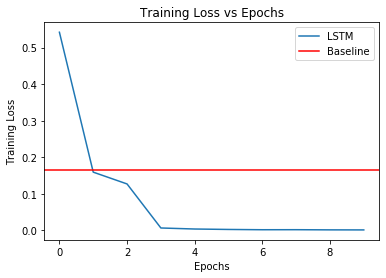

In [ ]:
print("********** Plotting **********")

y_baseline = np.ones((number_train_samples))
loss_baseline = np.mean((y_train - y_baseline) ** 2)

plt.plot(loss_history, label="LSTM")
plt.axhline(loss_baseline, label='Baseline', color='red')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Epochs')
plt.savefig('lstm.png')
plt.show()

In [ ]:
print("********** Testing LSTM **********")
loss = test(lstm, x_test, y_test)
print("Testing loss: ", loss)


********** Testing LSTM **********
Testing loss:  0.0022711730495549886


# GRU

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, number_of_layers):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.number_of_layers = number_of_layers

        # reset gate weights
        self.W_ir_list = nn.ParameterList([nn.Parameter(torch.randn(hidden_size, input_size if layer == 0 else hidden_size)) for layer in range(number_of_layers)])
        self.W_hr_list = nn.ParameterList([nn.Parameter(torch.randn(hidden_size, hidden_size)) for _ in range(number_of_layers)])
        self.b_r_list = nn.ParameterList([nn.Parameter(torch.randn(hidden_size)) for _ in range(number_of_layers)])

        # update gate weights
        self.W_iz_list = nn.ParameterList([nn.Parameter(torch.randn(hidden_size, input_size if layer == 0 else hidden_size)) for layer in range(number_of_layers)])
        self.W_hz_list = nn.ParameterList([nn.Parameter(torch.randn(hidden_size, hidden_size)) for _ in range(number_of_layers)])
        self.b_z_list = nn.ParameterList([nn.Parameter(torch.randn(hidden_size)) for _ in range(number_of_layers)])

        #
        self.W_ih_list = nn.ParameterList([nn.Parameter(torch.randn(hidden_size, input_size if layer == 0 else hidden_size)) for layer in range(number_of_layers)])
        self.W_hh_list = nn.ParameterList([nn.Parameter(torch.randn(hidden_size, hidden_size)) for _ in range(number_of_layers)])
        self.b_h_list = nn.ParameterList([nn.Parameter(torch.randn(hidden_size)) for _ in range(number_of_layers)])

        # output weights
        self.W_ho = nn.Parameter(torch.randn(output_size, hidden_size))
        self.b_o = nn.Parameter(torch.randn(output_size))

    def forward(self, x):
        h_list = [torch.zeros(self.hidden_size) for _ in range(self.number_of_layers)]

        for x_t in x:
            curr_in = x_t.float()
            curr_in = torch.reshape(curr_in, (x_t.shape[0], 1))
            for i in range(self.number_of_layers):
                rt = torch.sigmoid((torch.matmul(self.W_ir_list[i], curr_in) + torch.matmul(self.W_hr_list[i], h_list[i]) + self.b_r_list[i]).float())
                zt = torch.sigmoid((torch.matmul(self.W_iz_list[i], curr_in) + torch.matmul(self.W_hz_list[i], h_list[i]) + self.b_z_list[i]).float())
                h_t = torch.tanh((torch.matmul(self.W_ih_list[i], curr_in) + torch.matmul(self.W_hh_list[i], rt * h_list[i]) + self.b_h_list[i]).float())
                ht = ((1 - zt) * h_list[i]) + (zt * h_t)
                curr_in = ht.float()
                h_list[i] = ht.float()

        Y = torch.matmul(self.W_ho, h_list[-1]) + self.b_o
        return Y[-1][-1]

In [ ]:
number_train_samples = 5000
number_test_samples = 1000
max_length = 10
x_train, y_train = generate_dataset(number_train_samples, max_length)
x_test, y_test = generate_dataset(number_test_samples, max_length)
input_size = 2
hidden_size = 64
output_size = 1
number_of_layers = 3
learning_rate = 0.01
number_of_epochs = 10
print("Training data shape: ", x_train.shape)
print("Testing data shape: ", x_test.shape)
print("Training labels shape: ", y_train.shape)
print("Testing labels shape: ", y_test.shape)

Training data shape:  (5000,)
Testing data shape:  (1000,)
Training labels shape:  (5000,)
Testing labels shape:  (1000,)


In [ ]:
print("********** Training GRU **********")
print("Number of layers: ", number_of_layers)
print("Hidden size: ", hidden_size)
print("Learning rate: ", learning_rate)
print("Number of epochs: ", number_of_epochs)
print()

gru = GRU(input_size, hidden_size, output_size, number_of_layers)
loss_history = train(gru, x_train, y_train, learning_rate, number_of_epochs)

********** Training GRU **********
Number of layers:  3
Hidden size:  64
Learning rate:  0.01
Number of epochs:  10

===========> Epoch: 1, Loss: 4.223626085434666
===========> Epoch: 2, Loss: 0.24671673293772434
===========> Epoch: 3, Loss: 0.20928001168797933
===========> Epoch: 4, Loss: 0.17757704867806473
===========> Epoch: 5, Loss: 0.17589017528149847
===========> Epoch: 6, Loss: 0.16794419248240383
===========> Epoch: 7, Loss: 0.16348396835239762
===========> Epoch: 8, Loss: 0.1579013785414307
===========> Epoch: 9, Loss: 0.15871283158047012
===========> Epoch: 10, Loss: 0.15409778386181194


********** Plotting **********


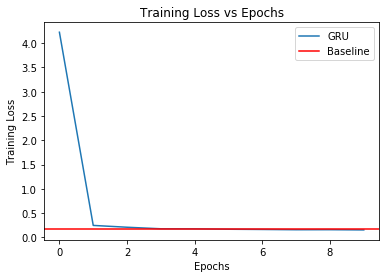

In [ ]:
print("********** Plotting **********")

y_baseline = np.ones((number_train_samples))
loss_baseline = np.mean((y_train - y_baseline) ** 2)

plt.plot(loss_history, label="GRU")
plt.axhline(loss_baseline, label='Baseline', color='red')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Epochs')
plt.savefig('gru.png')
plt.show()

In [ ]:
print("********** Testing GRU **********")
loss = test(gru, x_test, y_test)
print("Testing loss: ", loss)


********** Testing GRU **********
Testing loss:  0.14391279602730095
